In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#データの格納場所の確認
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [3]:
#トレーニングデータとテストデータの取得
df_train = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv')


#トレーニングデータの確認
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
#データの詳細
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
#欠損値を含む行数
df_train.isnull().any(axis=1).value_counts()


False    6606
True     2087
Name: count, dtype: int64

In [6]:
"""
欠損値を含むデータが多いので特徴量を絞る
"""

'\n欠損値を含むデータが多いので特徴量を絞る\n'

'\n全て約50%の割合で飛ばされているので、\n行き先に関係なくランダム飛ばされていることが分かる。\n\n'

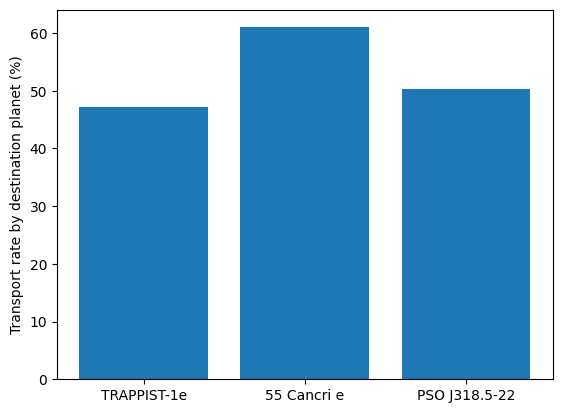

In [7]:
"""
行き先惑星の2番目の途中で飛ばされた可能性があるかもしれない
行き先惑星ごとの総人数で各飛ばされた割合を見る。
"""

#到着惑星における飛ばされた割合(%)
all_num = len(df_train.index)
dest_trans = df_train[['Destination', 'Transported']]

# ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
#↓行き先惑星ごとの飛ばされ率を総乗客で割った場合
# trains_rate = (dest_trans.groupby('Destination').sum() / all_num) * 100
# trains_rate['Transported'] = trains_rate['Transported'].round(1)
# trains_rate
# ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー

#各行き先惑星ごとの総人数
dest_count = dest_trans['Destination'].value_counts()

#各行き先惑星ごとの飛ばされた割合
dest_trans_sum = (dest_trans.groupby('Destination').sum())*100

#リスト変換
planet_rate = []
for planet in dest_count.index:
    rate = dest_trans_sum.loc[planet]/dest_count[planet]
    planet_rate.append(rate[0].round(2))

#棒グラフ
plt.bar(dest_count.index, planet_rate)
plt.ylabel('Transport rate by destination planet (%)')

"""
全て約50%の割合で飛ばされているので、
行き先に関係なくランダム飛ばされていることが分かる。

"""

'\n可能性は限りなくないが、念の為確認\n\u3000HomePlanetに関係なくランダムに飛ばされている。\n\n'

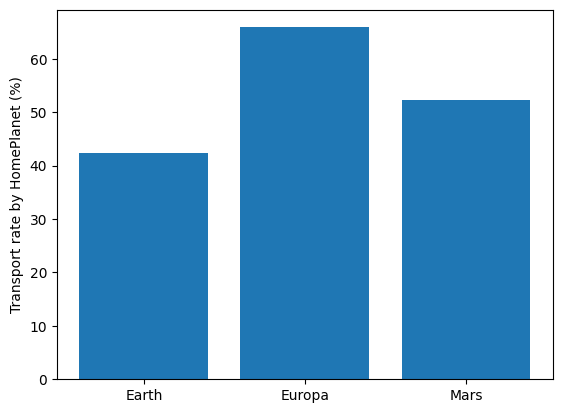

In [8]:
#乗客惑星ごとの総人数ーーーー関数で書けばよかった・・・・
home_df = df_train[['HomePlanet', 'Transported']]
home_count = home_df['HomePlanet'].value_counts()

#各行き先惑星ごとの飛ばされた割合
home_trans_sum = (home_df.groupby('HomePlanet').sum())*100

#リスト変換
home_rate = []
for planet in home_count.index:
    rate = home_trans_sum.loc[planet]/home_count[planet]
    home_rate.append(rate[0].round(2))

#棒グラフ
plt.bar(home_count.index, home_rate)
plt.ylabel('Transport rate by HomePlanet (%)')

"""
可能性は限りなくないが、念の為確認
　HomePlanetに関係なくランダムに飛ばされている。

"""

## データ加工

In [9]:
#不要と思われる特徴量の削除
#HomePlanet, Destination, Nameのカラムをドロップする
df_train_dro = df_train.drop(['HomePlanet', 'Destination', 'Name'], axis=1)
df_test_dro = df_test.drop(['HomePlanet', 'Destination', 'Name'], axis=1)




#PassengerIdの下2桁、Cabinのdeckだけ抽出 -> ラベルエンコーディング　（カテゴリ変数化）
#PassengerIdの下2桁を抽出し、intに変換
df_train_dro['GroupId'] = df_train_dro['PassengerId'].str.split('_', expand=True).loc[:,1].astype(int)
df_test_dro['GroupId'] = df_test_dro['PassengerId'].str.split('_', expand=True).loc[:,1].astype(int)

#Cabinのdeck文字だけ抽出
df_train_dro['Cabin_deck'] = df_train_dro['Cabin'].str.split('/', expand=True).loc[:, 0]
df_test_dro['Cabin_deck'] = df_test_dro['Cabin'].str.split('/', expand=True).loc[:, 0]

In [10]:
from sklearn.preprocessing import LabelEncoder

#目的のカラム名
select_cols = ['GroupId','Cabin_deck']

#ループでLabel encoding
for col in select_cols:
    le = LabelEncoder()
    le.fit(df_train_dro[col])
    df_train_dro[col] = le.transform(df_train_dro[col])
    df_test_dro[col] = le.transform(df_test_dro[col])
    

#PassengerIdとCabinカラムをドロップ    
df_train_dro = df_train_dro.drop(['PassengerId', 'Cabin'], axis=1)
test = df_test_dro.drop(['PassengerId', 'Cabin'], axis=1)

df_train_dro.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,Cabin_deck
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,1
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,5
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,0
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1,0
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0,5


In [11]:
#欠損値の確認
print('train data')
print(df_train_dro.isnull().any(axis=1).value_counts())
print('-'*25)
print('test data')
print(test.isnull().any(axis=1).value_counts())
print('-'*25)
print('各特徴量が持つ欠損値合計')
print(df_train_dro.isna().sum())

"""
各特徴量が持つ欠損値合計から、欠損値に偏りがなくさらに多くの特徴量に欠損値が一定量あるので、補完は難しい

決定木ベースのモデルだと欠損値でも扱えるのでこのまま実行してみる
"""

train data
False    7251
True     1442
Name: count, dtype: int64
-------------------------
test data
False    3575
True      702
Name: count, dtype: int64
-------------------------
各特徴量が持つ欠損値合計
CryoSleep       217
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
GroupId           0
Cabin_deck        0
dtype: int64


'\n各特徴量が持つ欠損値合計から、欠損値に偏りがなくさらに多くの特徴量に欠損値が一定量あるので、補完は難しい\n\n決定木ベースのモデルだと欠損値でも扱えるのでこのまま実行してみる\n'

# 特に何も考えず、LightGBMをしてみる

In [12]:
#スタビジさんとかめさんのLightGBMページ参照
#必要なモジュールをインポート

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score


In [13]:
#CryoSleepとVIPがobjetのなでboolに変換する(LightGBM用)
#2つだけの特徴量なのでハードコーディング
object_col = ['CryoSleep', 'VIP']

for col in object_col:
    df_train_dro[col] = df_train_dro[col].astype(bool)
    test[col] = test[col].astype(bool)
    
print(df_train_dro.dtypes)
df_train_dro

CryoSleep          bool
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
GroupId           int64
Cabin_deck        int64
dtype: object


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,Cabin_deck
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,1
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,5
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,0
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1,0
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0,5
...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,0,0
8689,True,18.0,False,0.0,0.0,0.0,0.0,0.0,False,0,6
8690,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,0,6
8691,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,0,4


In [14]:
#LightGBMの関数

def lgboost(X, y):
    
    #学習データを7:3で分ける、念の為、randam_stateも設定
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    #lgb.Dataset()でラップする
    train_data = lgb.Dataset(X_train, label=y_train)
    eval_data = lgb.Dataset(X_test, label=y_test)

    #ハイパーパラメータの設定
    #True, Falseの2値分類なので　binary
    #max_depthは3
    params = {
        'boosting_type':'gbdt',
        'objective':'binary',
        'max_depth':10,
        'random_state':0
    }

    model = lgb.train(params, train_data, valid_sets=eval_data, num_boost_round=100, callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation()])
    
    #特徴重要度
    lgb.plot_importance(model)

  
    #accuracyの計算
    pre_pred = model.predict(X_test)
    
    #値が0.5以上だと1, それ以外を0に変換
    pred = np.where(pre_pred >= 0.5, 1,  0)
    acu = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1_sc= f1_score(y_test, pred)
    
    print('-'*30)
    print(f'Accracy_score ： {acu}')
    print(f'Precision_score ： {pre}')
    print(f'Recall_score ： {rec}')
    print(f'F1_score ： {f1_sc}')
    print('-'*30)
    
  
    
    return model

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3073, number of negative: 3012
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505012 -> initscore=0.020050
[LightGBM] [Info] Start training from score 0.020050
[1]	valid_0's binary_logloss: 0.65462
Training until v

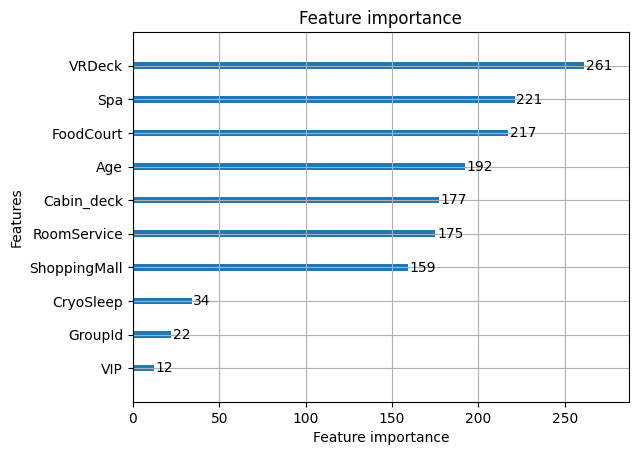

In [15]:
"""
Transportedに欠損値がないことを確認したのでテストデータと訓練データに分ける
"""
X = df_train_dro.drop('Transported', axis=1)
y = df_train_dro['Transported']

lgboost(X, y)


## 高級アメニティ系を削除してみる

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3073, number of negative: 3012
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505012 -> initscore=0.020050
[LightGBM] [Info] Start training from score 0.020050
[1]	valid_0's binary_logloss: 0.666817
Training until val

'\n逆にlogloss値が上昇した・・・\n高級アメニティは分類に必要みたい\n'

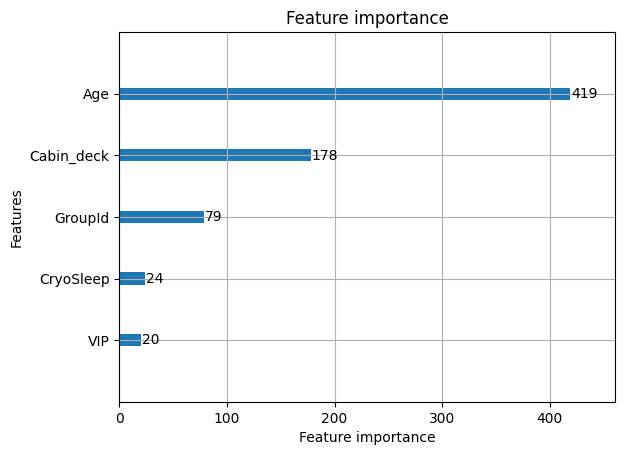

In [16]:
X_no_ani = df_train_dro.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported'], axis=1)
y = df_train_dro['Transported']

lgboost(X_no_ani, y)

"""
逆にlogloss値が上昇した・・・
高級アメニティは分類に必要みたい
"""

## 欠損値削除

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2674, number of negative: 2660
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
[1]	valid_0's binary_logloss: 0.652543
Training until 

'\n欠損値ない方が多少改善する\n'

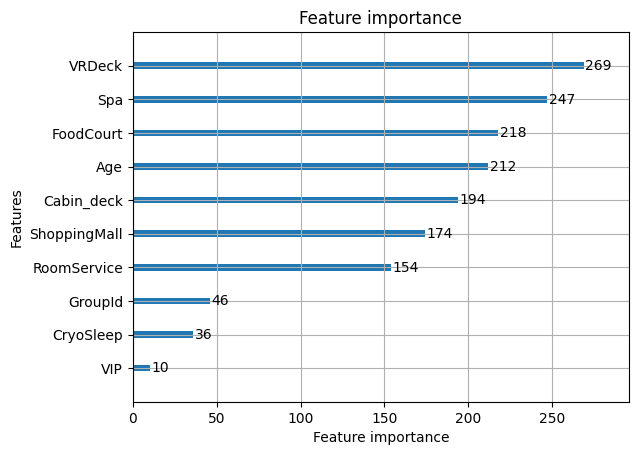

In [17]:
#各特徴量は一定量の欠損値を含んでいるので、補完は厳しい
#欠損値を含むデータを削除
X_drop = df_train_dro.dropna()
X = X_drop.drop('Transported', axis=1)
y = X_drop['Transported']

lgboost(X, y)

"""
欠損値ない方が多少改善する
"""

In [18]:
"""
特徴量重要度を見ると
VRDeckなどの高級アメニティ関係がかなり重要になっている

<今後>
①アメニティ関係を削除してもう一回 -> ligloss値悪化　<実施済み>
②欠損値をdropしたものでもう一回 -> ligloss値改善　<実施済み>
③age予想のモデルを作って、ageのnanを埋める
    ◻︎fancyimpute（多重代入法）で予想
     ・原理が少し曖昧、pythonの使用例の日本語サイトがない　＝＞　保留
    
    ◻︎K-最近傍法(k-NN)で予想
    ・ageのnan(testデータ)、ageのnanなし（訓練データ）のデータセットを作成
    ・k-NNをする

④Cabin_deckがハマっているので、deckとsideを組み合わせた特徴量を作ってみる？

ある程度loglossが改善したら、モデルのパラメータチューニング


"""

'\n特徴量重要度を見ると\nVRDeckなどの高級アメニティ関係がかなり重要になっている\n\n<今後>\n①アメニティ関係を削除してもう一回 -> ligloss値悪化\u3000<実施済み>\n②欠損値をdropしたものでもう一回 -> ligloss値改善\u3000<実施済み>\n③age予想のモデルを作って、ageのnanを埋める\n    ◻︎fancyimpute（多重代入法）で予想\n     ・原理が少し曖昧、pythonの使用例の日本語サイトがない\u3000＝＞\u3000保留\n    \n    ◻︎K-最近傍法(k-NN)で予想\n    ・ageのnan(testデータ)、ageのnanなし（訓練データ）のデータセットを作成\n    ・k-NNをする\n\n④Cabin_deckがハマっているので、deckとsideを組み合わせた特徴量を作ってみる？\n\nある程度loglossが改善したら、モデルのパラメータチューニング\n\n\n'

## 欠損値をできる限り埋めてみる

In [19]:
amenity_col =['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_train[df_train_dro[amenity_col].isna().any(axis=1)].head(20)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,False
23,0020_03,Earth,True,E/0/S,55 Cancri e,29.0,False,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,False
25,0020_05,Earth,True,E/0/S,PSO J318.5-22,1.0,False,NaN,0.0,0.0,0.0,0.0,Mael Brantuarez,False
28,0024_01,Europa,True,C/2/S,TRAPPIST-1e,62.0,False,0.0,0.0,NaN,0.0,0.0,Penton Fullided,True
35,0031_03,Mars,False,F/9/P,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,990.0,0.0,Dontch Datie,True
40,0039_01,Earth,True,G/1/P,55 Cancri e,30.0,False,0.0,0.0,NaN,0.0,0.0,Jorgie Batthewitt,False
48,0050_01,Earth,False,E/1/S,55 Cancri e,35.0,False,790.0,0.0,0.0,NaN,0.0,Sony Lancis,False
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,True


In [20]:
#Nanの偏りがなさそうなので、アメニティ関係のNanは０に変換
train_fill_ame = df_train_dro.copy()
test_fill_ame = test.copy()
train_fill_ame[amenity_col] = train_fill_ame[amenity_col].fillna(0)
test_fill_ame[amenity_col] = test_fill_ame[amenity_col].fillna(0)

print(train_fill_ame.isna().sum())
print(test_fill_ame.isna().sum())


CryoSleep         0
Age             179
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
GroupId           0
Cabin_deck        0
dtype: int64
CryoSleep        0
Age             91
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
GroupId          0
Cabin_deck       0
dtype: int64


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3073, number of negative: 3012
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505012 -> initscore=0.020050
[LightGBM] [Info] Start training from score 0.020050
[1]	valid_0's binary_logloss: 0.654296
Training until 

'\n高級アメニティをNanを0に埋めると、少し改善した。\n\nsubmitするとスコアは少し下がったので、あまり意味ない\n'

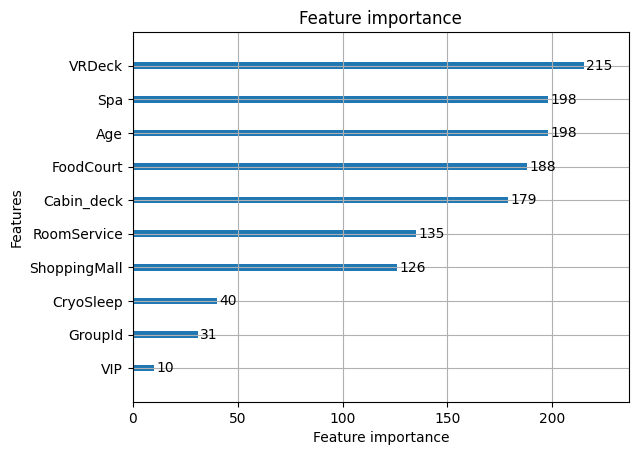

In [21]:
X = train_fill_ame.drop('Transported', axis=1)
y = train_fill_ame['Transported']

lgboost(X, y)

"""
高級アメニティをNanを0に埋めると、少し改善した。

submitするとスコアは少し下がったので、あまり意味ない
"""

# 提出用データの作成

In [22]:
#欠損値削除ver

# #テストデータでの予測
# test_pred = model.predict(test)

# #提出用のcsv作成
# submit_df = pd.DataFrame()
# submit_df['PassengerId'] = df_test['PassengerId']
# submit_df['Transported'] = np.where(test_pred >= 0.5, 1,  0).astype(bool)


# submit_df.to_csv('spaceship_titanic_1.csv')

In [23]:
"""
欠損値なしだと評価対象のPassengerIDの人も消してしまうので、欠損値は削除できない
lgboost関数だと、Save Versionの際に「modelは定義されてない」とエラーが出るので、関数なしでコードを記載しなおした。
↓
"""

'\n欠損値なしだと評価対象のPassengerIDの人も消してしまうので、欠損値は削除できない\nlgboost関数だと、Save Versionの際に「modelは定義されてない」とエラーが出るので、関数なしでコードを記載しなおした。\n↓\n'

In [24]:
#欠損値ありver

# X = df_train_dro.drop('Transported', axis=1)
# y = df_train_dro['Transported']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# #lgb.Dataset()でラップする
# train_data = lgb.Dataset(X_train, label=y_train)
# eval_data = lgb.Dataset(X_test, label=y_test)

# #ハイパーパラメータの設定
# #True, Falseの2値分類なので　binary
# #max_depthは3
# params = {
#     'boosting_type':'gbdt',
#     'objective':'binary',
#     'max_depth':10,
#     'random_state':0
# }

# model = lgb.train(params, train_data, valid_sets=eval_data, num_boost_round=100, callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation()])


# #テストデータでの予測
# test_pred2 = model.predict(test)

# #提出用のcsv作成
# submit_df = pd.DataFrame()
# submit_df['PassengerId'] = df_test['PassengerId']
# submit_df['Transported'] = np.where(test_pred2 >= 0.5, 1,  0).astype(bool)


# submit_df.to_csv('spaceship_titanic_1.csv', index=False)

In [25]:
#高級アメニティの欠損値を埋めたver

X = train_fill_ame.drop('Transported', axis=1)
y = train_fill_ame['Transported']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#lgb.Dataset()でラップする
train_data = lgb.Dataset(X_train, label=y_train)
eval_data = lgb.Dataset(X_test, label=y_test)

#ハイパーパラメータの設定
#True, Falseの2値分類なので　binary
#max_depthは3
params = {
    'boosting_type':'gbdt',
    'objective':'binary',
    'max_depth':10,
    'random_state':0
}

model = lgb.train(params, train_data, valid_sets=eval_data, num_boost_round=100, callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation()])

#値が0.5以上だと1, それ以外を0に変換
pre_pred = model.predict(X_test)
pred = np.where(pre_pred >= 0.5, 1,  0)
acu = accuracy_score(y_test, pred)
pre = precision_score(y_test, pred)
rec = recall_score(y_test, pred)
f1_sc= f1_score(y_test, pred)

print('-'*30)
print(f'Accracy_score ： {acu}')
print(f'Precision_score ： {pre}')
print(f'Recall_score ： {rec}')
print(f'F1_score ： {f1_sc}')
print('-'*30)

#テストデータでの予測
test_pred2 = model.predict(test_fill_ame)


#提出用のcsv作成
submit_df = pd.DataFrame()
submit_df['PassengerId'] = df_test['PassengerId']
submit_df['Transported'] = np.where(test_pred2 >= 0.5, 1,  0).astype(bool)


submit_df.to_csv('spaceship_titanic_1.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3073, number of negative: 3012
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505012 -> initscore=0.020050
[LightGBM] [Info] Start training from score 0.020050
[1]	valid_0's binary_logloss: 0.654296
Training until 